# Telecom Customer Churn 
blog on kaggle: https://www.kaggle.com/lynneicem/predicting-customer-churn

Column descriptions:
customerID - customer id

gender - client gender (male / female)

SeniorCitizen - is the client retired (1, 0)

Partner - is the client married (Yes, No)

tenure - how many months a person has been a client of the company

PhoneService - is the telephone service connected (Yes, No)

MultipleLines - are multiple phone lines connected (Yes, No, No phone service)

InternetService - client's Internet service provider (DSL, Fiber optic, No)

OnlineSecurity - is the online security service connected (Yes, No, No internet service)

OnlineBackup - is the online backup service activated (Yes, No, No internet service)
DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)

TechSupport - is the technical support service connected (Yes, No, No internet service)

StreamingTV - is the streaming TV service connected (Yes, No, No internet service)

StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)

Contract - type of customer contract (Month-to-month, One year, Two year)

PaperlessBilling - whether the client uses paperless billing (Yes, No)

PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges - current monthly payment

TotalCharges - the total amount that the client paid for the services for the entire time

Churn - whether there was a churn (Yes or No)


In [1]:
#Dataset of choice: https://www.kaggle.com/radmirzosimov/telecom-users-dataset
#!pip install pandas-profiling==3.0.0

In [2]:
#import required libraries 
import pandas as pd
import numpy as np
import plotly.express as px
from pandas_profiling import ProfileReport
import re
from functools import reduce

In [3]:
#constant path variable
PATH = "/content/telecom_users.csv"

In [4]:
#read in the csv
df = pd.read_csv(PATH)
df.head(30)

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No
5,2215,4312-GVYNH,Female,0,Yes,No,70,No,No phone service,DSL,Yes,No,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),49.85,3370.2,No
6,5260,2495-KZNFB,Female,0,No,No,33,Yes,Yes,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,90.65,2989.6,No
7,6001,4367-NHWMM,Female,0,No,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,24.90,24.9,No
8,1480,8898-KASCD,Male,0,No,No,39,No,No phone service,DSL,No,No,Yes,Yes,No,No,One year,No,Mailed check,35.55,1309.15,No
9,5137,8016-NCFVO,Male,1,No,No,55,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,116.50,6382.55,No


In [5]:
#these are already split into yes/no so I'll change them to binaary 
binary_columns = [ 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',	'StreamingTV',	'StreamingMovies', 'PaperlessBilling', 'Churn']

#using ordinal for EDA since No internet is worse than DSL which is slower (lower quality) than Fiber Optic; will use pipeline in model
ordinal_columns = ['InternetService']

#use one hot encoding for categorical variables
one_hot= ['gender', 'Contract', 'PaymentMethod' ]

In [6]:
#check the string values in the bool columns
pd.unique(df['PhoneService'])

array(['Yes', 'No'], dtype=object)

In [7]:
#using this to ensure encoding doesn't mess up the data; run once before wrangle() is called and once after [5396 YES]
df['PhoneService'].value_counts()

Yes    5396
No      590
Name: PhoneService, dtype: int64

In [8]:
#also checking the ordinal cols
df['InternetService'].value_counts()

Fiber optic    2627
DSL            2068
No             1291
Name: InternetService, dtype: int64

In [9]:
#check the column names
df.columns

Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [10]:
#Cleaning
def wrangle(df):
  
  #drop unneeded ID cols
  df = df.drop(columns=['Unnamed: 0', 'customerID'])
  
  #Convert binary cols
  for col in df[binary_columns]:
    df.fillna(0, inplace=True)

  #make yes = 1, else 0
  df[binary_columns] = (df[binary_columns] == 'Yes').astype(int)

  #change total charges to float
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

  #one-hot encoding
  df = pd.get_dummies(df, columns = one_hot)
  
  train = df

  return train

In [11]:
train = wrangle(df)
train

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,72,1,1,No,0,0,0,0,0,0,0,24.10,1734.65,0,0,1,0,0,1,0,1,0,0
1,0,0,0,44,1,0,Fiber optic,0,1,1,0,1,0,1,88.15,3973.20,0,1,0,1,0,0,0,1,0,0
2,1,1,0,38,1,1,Fiber optic,0,0,0,0,0,0,1,74.95,2869.85,1,1,0,1,0,0,1,0,0,0
3,0,0,0,4,1,0,DSL,0,0,0,0,0,1,1,55.90,238.50,0,0,1,1,0,0,0,0,1,0
4,0,0,0,2,1,0,DSL,1,0,1,0,0,0,0,53.45,119.50,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0,1,0,1,1,0,Fiber optic,1,0,0,0,1,1,1,95.00,95.00,1,0,1,1,0,0,0,0,1,0
5982,0,1,1,23,1,1,DSL,1,1,1,1,1,1,1,91.10,2198.30,0,1,0,0,0,1,0,1,0,0
5983,0,1,1,12,1,0,No,0,0,0,0,0,0,1,21.15,306.05,0,0,1,1,0,0,0,0,1,0
5984,1,0,0,12,1,1,Fiber optic,0,0,1,0,1,1,1,99.45,1200.15,1,0,1,1,0,0,0,0,1,0


It looks like Tenure is equivalent to the customer lifetime, and total charges is their lifetime value, so we are able to calculate the client's Average Customer Lifetime and Avg. Customer Lifetime Value from this data. 


In [12]:
#average customer lifetime
train['tenure'].mean()

32.46876044102907

In [13]:
#avg. lifetime value
train['TotalCharges'].mean()

2298.0606174698796

In [14]:
train = wrangle(df)
train

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,72,1,1,No,0,0,0,0,0,0,0,24.10,1734.65,0,0,1,0,0,1,0,1,0,0
1,0,0,0,44,1,0,Fiber optic,0,1,1,0,1,0,1,88.15,3973.20,0,1,0,1,0,0,0,1,0,0
2,1,1,0,38,1,1,Fiber optic,0,0,0,0,0,0,1,74.95,2869.85,1,1,0,1,0,0,1,0,0,0
3,0,0,0,4,1,0,DSL,0,0,0,0,0,1,1,55.90,238.50,0,0,1,1,0,0,0,0,1,0
4,0,0,0,2,1,0,DSL,1,0,1,0,0,0,0,53.45,119.50,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0,1,0,1,1,0,Fiber optic,1,0,0,0,1,1,1,95.00,95.00,1,0,1,1,0,0,0,0,1,0
5982,0,1,1,23,1,1,DSL,1,1,1,1,1,1,1,91.10,2198.30,0,1,0,0,0,1,0,1,0,0
5983,0,1,1,12,1,0,No,0,0,0,0,0,0,1,21.15,306.05,0,0,1,1,0,0,0,0,1,0
5984,1,0,0,12,1,1,Fiber optic,0,0,1,0,1,1,1,99.45,1200.15,1,0,1,1,0,0,0,0,1,0


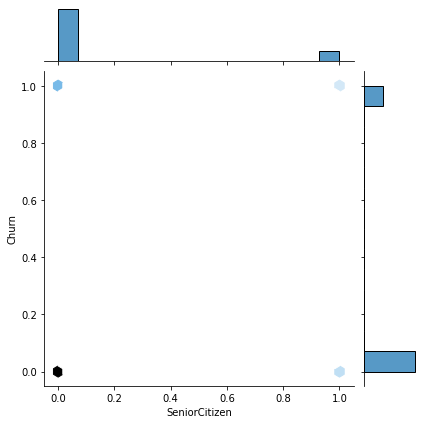

In [15]:
import seaborn as sns
%matplotlib inline

# For 
sns.jointplot(x = train['SeniorCitizen'], y = train['Churn'], kind = 'hex');


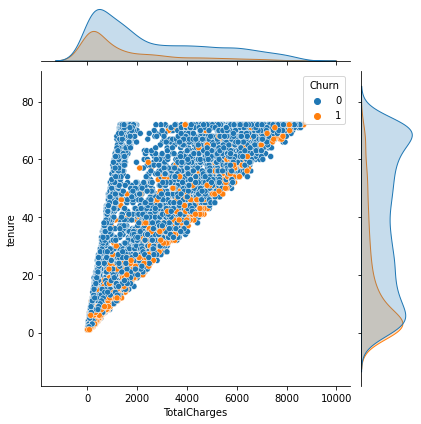

In [16]:
sns.jointplot(data=train, x="TotalCharges", y="tenure", hue="Churn");

There is a crude observation to be made that to an extent, once a customer has been retained for a certain period, given their average charges increases or stays the same, their liklihood of churn decreases to nearly zero. We will see what the model suggests.

In [17]:
train['TotalCharges']

0       1734.65
1       3973.20
2       2869.85
3        238.50
4        119.50
         ...   
5981      95.00
5982    2198.30
5983     306.05
5984    1200.15
5985     457.30
Name: TotalCharges, Length: 5986, dtype: float64

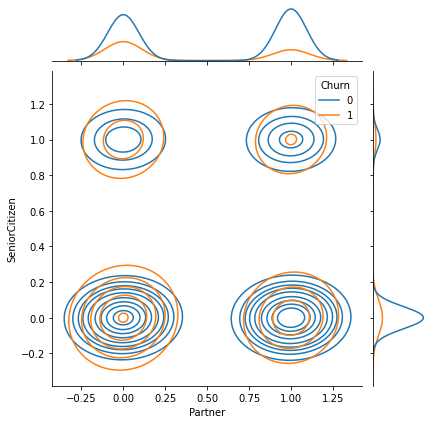

In [18]:
sns.jointplot(data=train, x="Partner", y="SeniorCitizen", hue="Churn", kind="kde")


There is low liklihood of churn among older customers who likely have been retained over time.

In [19]:
train['DeviceProtection'].value_counts()

0    3931
1    2055
Name: DeviceProtection, dtype: int64

In [20]:
#check dtypes to refine wrangle function above; most binary cols are objects (Str) and need to be converted
train.dtypes

SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
InternetService                             object
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
gender_Female                                uint8
gender_Male                                  uint8
Contract_Month-to-month        

In [21]:
['gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn']

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [22]:
#average customer lifetime
train['tenure'].mean()

32.46876044102907

In [23]:
#on average how long does a 'good' contract last?
non_churn = train[train['Churn']==0]
non_churn['tenure'].mean()

37.59968174585133

In [24]:
#on average how many months before a churn?
churn_customers = train[train['Churn']==1]
churn_customers['tenure'].mean()

18.246376811594203

Based on this information they may want to consider optimizing their contract structure to better catch potential churn prior to a 12 or 24 month contract ending prematurely. There may be nurture opportunities to survey customers at certain points in their tenrue to aid retention. Premium packages are great, but so are rewards. Incentivization may also aid in retention if placed just before the 19 month mark in high-risk applicants. 

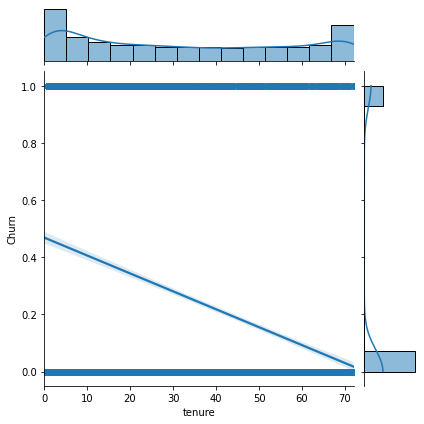

In [25]:
sns.jointplot(data=train, x="tenure", y="Churn", kind="reg")

In [26]:
#avg. lifetime value
train['TotalCharges'].mean()

2298.0606174698796

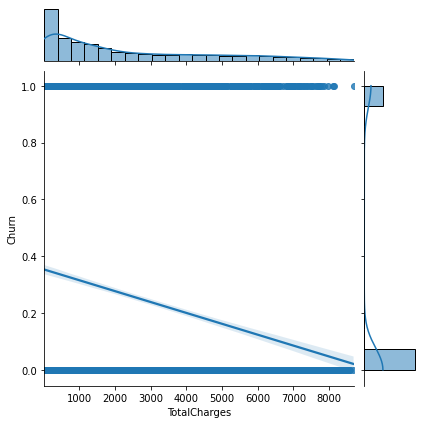

In [27]:
sns.jointplot(data=train, x="TotalCharges", y="Churn", kind="reg")

# More Exploratory Data Analysis


In [28]:
#identify target and fetures matrix
target = 'Churn'
features = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

#import library for split
from sklearn.model_selection import train_test_split

In [29]:
#split into train, val, test sets
train, val = train_test_split(train, test_size = 0.3, random_state=13)

val, test = train_test_split(val, test_size = 0.3, random_state=13)

In [30]:
#double-check the shapes
print(train.shape)
print(val.shape)
print(test.shape)

(4190, 26)
(1257, 26)
(539, 26)


In [31]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


In [32]:
#check the shape
X_val.shape

(1257, 25)

In [33]:
#explore the data w/linear
px.scatter(
    train, x='tenure', y='Churn', trendline='ols'
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [34]:
train.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4182.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000
mean,0.161098,0.485680,0.296897,32.502148,0.905489,0.430072,0.282100,0.345585,0.341766,0.287351,0.387112,0.396181,0.586874,64.993520,2318.245684,0.265155,0.487112,0.512888,0.540573,0.216945,0.242482,0.212888,0.216229,0.344391,0.226492
std,0.367665,0.499855,0.456945,24.503246,0.292573,0.495145,0.450076,0.475615,0.474358,0.452581,0.487148,0.489161,0.492454,30.106864,2286.773645,0.441468,0.499894,0.499894,0.498411,0.412214,0.428635,0.409398,0.411721,0.475226,0.418611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.900000,401.437500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.600000,1424.700000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3902.150000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
# !pip install pandas-profiling==2.7.1

In [36]:
# profile = ProfileReport(train)

# profile.to_notebook_iframe()

In [37]:
#establish baseline: ('NO')
y_pred = y_train.mode()[0] * len(y_train)

In [38]:
#accuracy is about 74% at baseline
y_train.value_counts(normalize=True)

0    0.734845
1    0.265155
Name: Churn, dtype: float64

#Linear models: Passive Aggressive Classifier + hyperparameter tuning

In [44]:
#Using PAC for its ability to penalize incorrect predictions over epochs according to C value (normalization)
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
!pip install category-encoders

import category_encoders as ce
from sklearn.preprocessing import StandardScaler


In [45]:


#setting up parameter dict
params = {
    'C':[0.1, 0.5, 1.0], 
    'max_iter': [1000], 
    'tol':[0.001, 0.01, 0.1], 
    'validation_fraction': [0.7], 
    'n_iter_no_change': [20], 
    'verbose': [1], 
    'loss': ["hinge"], 
    'n_jobs': [-1], 
    'random_state': [13], 
    'class_weight': ["balanced"]
}



#run vanilla to see what I am optimizing
pac = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'),
    PassiveAggressiveClassifier(C=0.55, 
                                random_state=13)
)

pac.fit(X_train, y=y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['InternetService'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'InternetService',
                                          'data_type': dtype('O'),
                                          'mapping': No             1
DSL            2
Fiber optic    3
NaN           -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std...
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('passiveaggressiveclassifier',
                 PassiveAggressiveClassifier(C=0.55, average=False,
                                             class_weight=None,
                                             early

In [46]:
#Making predictions on val set
y_pred = pac.predict(X_val)

In [47]:
#Model evaluation
print(f"Test set Accuracy: {accuracy_score(y_val, y_pred) * 100} %\n\n")

print(f"Classification Report: \n\n{classification_report(y_val,y_pred)}")

Test set Accuracy: 70.48528241845663 %


Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       942
           1       0.41      0.40      0.40       315

    accuracy                           0.70      1257
   macro avg       0.60      0.60      0.60      1257
weighted avg       0.70      0.70      0.70      1257



Passive Aggressive Classifier 
w/default params

Test set Accuracy: 70.48528241845663 %


Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       942
           1       0.41      0.40      0.40       315

    accuracy                           0.70      1257
   macro avg       0.60      0.60      0.60      1257
weighted avg       0.70      0.70      0.70      1257




The model is struggling in both recall and precision for positive predictions on the target. Precision refers to the model's ability to accurately predict True Positive results. It is a represenation of how many actual True positives were accurately predicted out of all those positive predictions.

Recall refers to the set of all actual True positives there are, and specifically is a measure of what percentage the model accurately labeled.

In [48]:
#using dict above I tried multiple sets of parameters

pac = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'),
    PassiveAggressiveClassifier(C=0.0001, #maximum step size
                                tol=0.0001, #stopping criteria
                                n_iter_no_change= 10, #no of iterations to execute w/o change before stopping
                                loss= "hinge", #square-hinge reduced accuracy as C was made smaller
                                n_jobs= -1,
                                fit_intercept=True, 
                                max_iter=2000, #upping this increased accuracy as well
                                random_state=13)
)

pac.fit(X_train, y=y_train)
#Making predictions on test set
y_pred = pac.predict(X_val)

#Model evaluation
print(f"Val set Accuracy: {accuracy_score(y_val, y_pred) * 100} %\n\n")

print(f"Classification Report: \n\n{classification_report(y_val,y_pred)}")

Val set Accuracy: 80.58870326173428 %


Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       942
           1       0.64      0.51      0.57       315

    accuracy                           0.81      1257
   macro avg       0.74      0.71      0.72      1257
weighted avg       0.80      0.81      0.80      1257



In [49]:
predict = pac.predict(X_test)


print(f"test set Accuracy: {accuracy_score(y_test, predict) * 100} %\n\n")

print(f"Classification Report: \n\n{classification_report(y_test,predict)}")

test set Accuracy: 78.84972170686456 %


Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       378
           1       0.69      0.54      0.60       161

    accuracy                           0.79       539
   macro avg       0.75      0.72      0.73       539
weighted avg       0.78      0.79      0.78       539



Precision and recall are much higher now. We care about Recall a bit more in this case because it's more important to 

#Logistic Regression + AdaBoost Classifier + Hyperparameter Tuning

In [50]:
#import libs
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV

In [51]:
#instantiate LR object for GS
log_regress = LogisticRegressionCV()
log_regress.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [52]:
#!pip install category_encoders
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(),
    SimpleImputer(strategy='mean'), 
    LogisticRegressionCV(n_jobs=-1, max_iter=1000, random_state=13)
)

#fit on train, and score on val 
pipeline.fit(X_train, y_train)
print('val accuracy is', pipeline.score(X_val, y_val))


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



val accuracy is 0.8058870326173428


Accuracy on val is 81%

In [53]:
pipeline.named_steps

{'logisticregressioncv': LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                      fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                      max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2',
                      random_state=13, refit=True, scoring=None, solver='lbfgs',
                      tol=0.0001, verbose=0),
 'onehotencoder': OneHotEncoder(cols=['InternetService'], drop_invariant=False,
               handle_missing='value', handle_unknown='value', return_df=True,
               use_cat_names=True, verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

#AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier

abc = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'),
    AdaBoostClassifier(n_estimators=200, 
                       learning_rate=0.1, 
                       random_state=13)
)

abc.fit(X_train, y=y_train)
print('Validation Accuracy: AdaBoosted Classifier', abc.score(X_val, y_val))


#predict on test
y_pred1 = abc.predict_proba(X_test)
print('Test Accuracy: AdaBoosted Classifier', abc.score(X_test, y_test))

Validation Accuracy: AdaBoosted Classifier 0.7907716785998409
Test Accuracy: AdaBoosted Classifier 0.8051948051948052


#Parameter Tuning:
Tried: With and without scaling; Accuracy 71 before scaling, 77 after scaling

Tried: SimpleImputer fill na w/mean values: accuracy 73.8

Tried SimpleImputer fill na w/ median, increased # of estimators, accuracy 78.4

Decreased 'learning rate' to change weights on each classifier after each boosting iteration. Val accuracy after slowing learning rate to 0.1: 79%

Random State unchanged for reproducability. 13 is my birthday.

**Val Accuracy on final model is 79.1%**

**Test Accuracy on final model is 80.5%**



In [55]:
!pip install shap
import shap
shap.initjs()

     |████████████████████████████████| 358kB 7.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=91559524408de53c0fac77b0027bc6055ec778fd724b4b0542ac790f0f3caf84
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [56]:
clf= abc.named_steps['adaboostclassifier']

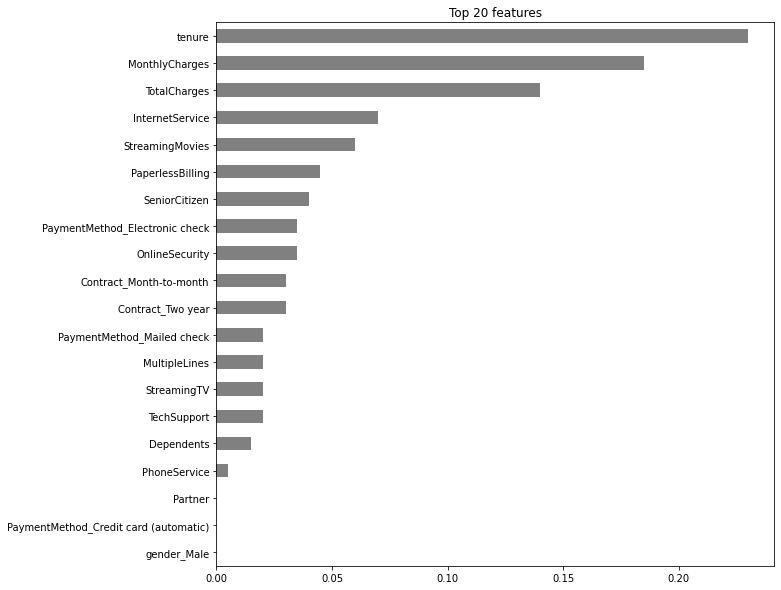

In [57]:
# Get feature importances
importances = pd.Series(clf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In the future I would like to further explore how long it takes for high risk users to Churn. The final analysis is useful as it is more important to be able to prioritize customers who are more likely to result in a long tenure and larger lifetime value to the company.

Canceled contracts cut into the bottom line, so being able to rely on a model to accurately flag more potentially lucrative contracts by their unlikliness to churn is important. The model built here has high Precision, accurately predicting a large number of potentially good contracts and users likely to churn without racking up large volumes of false positives. False positives could mean turning down applicants who may be lucrative contracts down the line and deprioritizing good applicants.



https://colab.research.google.com/drive/1d39CrVXab4-az-ISrlAhAwvzCWgn5o0h?usp=sharing